--- 

<img src="Logo_inpt.png" alt="Drawing" style="width: 160px;" align= "right"/> 

# Exploration , Étude Statistique 📊 et Prédictive 📈 des Vidéos Youtube      Tendances dans 5 Pays : Maroc 🇲🇦, Usa 🇺🇸, Espagne 🇪🇸, France 🇫🇷, Italie 🇮🇹

--- 

> _Situation du Dimanche **12 Avril 2020**_  

### Groupe :           ***JVLIVS***                                                                                                     
>- ELAOUMARI Chaimae
>- MANOUZI -OUTMANI Mouad              

### Encadré par : 
>- Mr.Abdelhak Mahmoudi                          

> ### ✅ Construction des 5 Datasets en utilisant le *Web Scraping*

In [176]:
### Recuperation des videos tendances sur Youtube dans les 5 Pays le 12/04/2020 

import requests, sys, time, os

# List of simple to collect features
snippet_features = ["title",
                    "publishedAt",
                    "channelId",
                    "channelTitle",
                    "categoryId"]

# Any characters to exclude, generally these are things that become problematic in CSV files
unsafe_characters = ['\n', '"']

# Used to identify columns, currently hardcoded order
header = ["video_id"] + snippet_features + ["trending_date", "tags", "view_count", "likes", "dislikes",
                                            "comment_count", "thumbnail_link", "comments_disabled",
                                            "ratings_disabled", "description"]


def setup(api_path, code_path):
    with open(api_path, 'r') as file:
        api_key = file.readline()

    with open(code_path) as file:
        country_codes = [x.rstrip() for x in file]

    return api_key, country_codes


def prepare_feature(feature):
    # Removes any character from the unsafe characters list and surrounds the whole item in quotes
    for ch in unsafe_characters:
        feature = str(feature).replace(ch, "")
    return f'"{feature}"'


def api_request(page_token, country_code):
    # Builds the URL and requests the JSON from it
    request_url = f"https://www.googleapis.com/youtube/v3/videos?part=id,statistics,snippet{page_token}chart=mostPopular&regionCode={country_code}&maxResults=50&key={api_key}"
    request = requests.get(request_url)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()
    return request.json()


def get_tags(tags_list):
    # Takes a list of tags, prepares each tag and joins them into a string by the pipe character
    return prepare_feature("|".join(tags_list))


def get_videos(items):
    lines = []
    for video in items:
        comments_disabled = False
        ratings_disabled = False

        # We can assume something is wrong with the video if it has no statistics, often this means it has been deleted
        # so we can just skip it
        if "statistics" not in video:
            continue

        # A full explanation of all of these features can be found on the GitHub page for this project
        video_id = prepare_feature(video['id'])

        # Snippet and statistics are sub-dicts of video, containing the most useful info
        snippet = video['snippet']
        statistics = video['statistics']

        # This list contains all of the features in snippet that are 1 deep and require no special processing
        features = [prepare_feature(snippet.get(feature, "")) for feature in snippet_features]

        # The following are special case features which require unique processing, or are not within the snippet dict
        description = snippet.get("description", "")
        thumbnail_link = snippet.get("thumbnails", dict()).get("default", dict()).get("url", "")
        trending_date = time.strftime("%y.%d.%m")
        tags = get_tags(snippet.get("tags", ["[none]"]))
        view_count = statistics.get("viewCount", 0)

        # This may be unclear, essentially the way the API works is that if a video has comments or ratings disabled
        # then it has no feature for it, thus if they don't exist in the statistics dict we know they are disabled
        if 'likeCount' in statistics and 'dislikeCount' in statistics:
            likes = statistics['likeCount']
            dislikes = statistics['dislikeCount']
        else:
            ratings_disabled = True
            likes = 0
            dislikes = 0

        if 'commentCount' in statistics:
            comment_count = statistics['commentCount']
        else:
            comments_disabled = True
            comment_count = 0

        # Compiles all of the various bits of info into one consistently formatted line
        line = [video_id] + features + [prepare_feature(x) for x in [trending_date, tags, view_count, likes, dislikes,
                                                                       comment_count, thumbnail_link, comments_disabled,
                                                                       ratings_disabled, description]]
        lines.append(",".join(line))
    return lines


def get_pages(country_code, next_page_token="&"):
    country_data = []

    # Because the API uses page tokens (which are literally just the same function of numbers everywhere) it is much
    # more inconvenient to iterate over pages, but that is what is done here.
    while next_page_token is not None:
        # A page of data i.e. a list of videos and all needed data
        video_data_page = api_request(next_page_token, country_code)

        # Get the next page token and build a string which can be injected into the request with it, unless it's None,
        # then let the whole thing be None so that the loop ends after this cycle
        next_page_token = video_data_page.get("nextPageToken", None)
        next_page_token = f"&pageToken={next_page_token}&" if next_page_token is not None else next_page_token

        # Get all of the items as a list and let get_videos return the needed features
        items = video_data_page.get('items', [])
        country_data += get_videos(items)

    return country_data


def write_to_file(country_code, country_data):

    print(f"Writing {country_code} data to file...")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(f"{output_dir}/{time.strftime('%y.%d.%m')}_{country_code}_videos.csv", "w+", encoding='utf-8') as file:
        for row in country_data:
            file.write(f"{row}\n")


def get_data():
    for country_code in country_codes:
        country_data = [",".join(header)] + get_pages(country_code)
        write_to_file(country_code, country_data)


if __name__ == "__main__":
              
    args = ('ML_Project/Youtube_API_key.txt' ,'ML_Project/Country_codes.txt','ML_Project/DataBase')
              
    api_key, country_codes = setup(args[0], args[1])
    output_dir = args[2]

    get_data()

Writing MA data to file...
Writing US data to file...
Writing FR data to file...
Writing ES data to file...
Writing IT data to file...


> ###  ✅ Importation des Librarys nécessaires. <br><br> ✅ Configuration de l'environnement de travail.

In [177]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib.axes._axes import _log as matplotlib_axes_logger 
    
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='serif', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

> ### ✅ Lecture des 5 Databases générés.

In [3]:
MA = pd.read_csv('ML_Project/DataBase/20.12.04_MA_videos.csv')
US = pd.read_csv('ML_Project/DataBase/20.12.04_US_videos.csv')
FR = pd.read_csv('ML_Project/DataBase/20.12.04_FR_videos.csv')
ES = pd.read_csv('ML_Project/DataBase/20.12.04_ES_videos.csv')
IT = pd.read_csv('ML_Project/DataBase/20.12.04_IT_videos.csv')

In [5]:
MA.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,X3KEpjaHYJM,صراع العمالقة | الحلقة التاسعة | سديم 3,2020-04-11T18:00:11.000Z,UCWxc7ue-jGlL5ypOHX_i0Bg,Official Sadeem,22,20.12.04,sadeem|أحمد شريف|ديزاد جوكر|شريف فايد|Sherif F...,1690271,183044,2920,66961,https://i.ytimg.com/vi/X3KEpjaHYJM/default.jpg,False,False,التحدّي النهائي صعب جداً والمنافسة طاحنة بين أ...
1,zVYlKn28P7k,أحتاج إليكم ...,2020-04-11T21:34:18.000Z,UCuvhvj28Vx9-eqDS0mScLhA,Adil Taouil l عادل تاويل,22,20.12.04,adil taouil|عادل تاويل|الراب المغربي|برنامج تر...,368205,106019,2384,12766,https://i.ytimg.com/vi/zVYlKn28P7k/default.jpg,False,False,رابط التصويت https://voting.sadeem.com/
2,lRIDDhSBLKo,بداية جديدة | رحلة البطل | تحدي سديم 3,2020-04-10T17:00:08.000Z,UCuvhvj28Vx9-eqDS0mScLhA,Adil Taouil l عادل تاويل,22,20.12.04,adil taouil|عادل تاويل|sadeem|sadeem3|قصة عادل...,1634033,265238,9746,50271,https://i.ytimg.com/vi/lRIDDhSBLKo/default.jpg,False,False,Contact info\r\rINSTAGRAM : @adiltaouil\rFACEB...
3,_bhYN5nwCR8,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...,2020-04-12T00:00:10.000Z,UCvheXmI5oWFZoy9VrKCl51w,MR CRAZY OFFICIAL,10,20.12.04,[none],201076,28759,1485,1795,https://i.ytimg.com/vi/_bhYN5nwCR8/default.jpg,False,False,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...
4,u3WVyu64kCg,Elissa ... Hanghani Kaman Wi Kaman - 2020 | إل...,2020-04-11T17:06:23.000Z,UCNhqvQMXIgRfjAGmxQqdNRw,Rotana,10,20.12.04,Arabic|Arab|Tarab|Music|Song|Rotana|روتانا|عرب...,1415712,90635,3628,7583,https://i.ytimg.com/vi/u3WVyu64kCg/default.jpg,False,False,كلمات : شادي نورألحان : محمد يحييفواصل موسيقه ...


> ### ✅ Concaténation des 5 Databases en une seule avec ajout d'une colonne ‘Pays’ pour distinguer les vidéos de chaque Pays.

In [4]:
MA.insert(0, 'Pays', 'Morocco')
US.insert(0, 'Pays', 'Usa')
FR.insert(0, 'Pays', 'France')
ES.insert(0, 'Pays', 'Spain')
IT.insert(0, 'Pays', 'Italy')

In [5]:
Les_5_pays = [MA,US,FR,ES,IT] 
Youtube = pd.concat(Les_5_pays)

> ## ✔️ Data Pre-Processing

In [6]:
# Dimensions of Dataset
Youtube.shape

(1000, 17)

In [7]:
Youtube.head()

,Pays,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,Morocco,X3KEpjaHYJM,صراع العمالقة | الحلقة التاسعة | سديم 3,2020-04-11T18:00:11.000Z,UCWxc7ue-jGlL5ypOHX_i0Bg,Official Sadeem,22,20.12.04,sadeem|أحمد شريف|ديزاد جوكر|شريف فايد|Sherif F...,1690271,183044,2920,66961,https://i.ytimg.com/vi/X3KEpjaHYJM/default.jpg,False,False,التحدّي النهائي صعب جداً والمنافسة طاحنة بين أ...
1,Morocco,zVYlKn28P7k,أحتاج إليكم ...,2020-04-11T21:34:18.000Z,UCuvhvj28Vx9-eqDS0mScLhA,Adil Taouil l عادل تاويل,22,20.12.04,adil taouil|عادل تاويل|الراب المغربي|برنامج تر...,368205,106019,2384,12766,https://i.ytimg.com/vi/zVYlKn28P7k/default.jpg,False,False,رابط التصويت https://voting.sadeem.com/
2,Morocco,lRIDDhSBLKo,بداية جديدة | رحلة البطل | تحدي سديم 3,2020-04-10T17:00:08.000Z,UCuvhvj28Vx9-eqDS0mScLhA,Adil Taouil l عادل تاويل,22,20.12.04,adil taouil|عادل تاويل|sadeem|sadeem3|قصة عادل...,1634033,265238,9746,50271,https://i.ytimg.com/vi/lRIDDhSBLKo/default.jpg,False,False,Contact info\r\rINSTAGRAM : @adiltaouil\rFACEB...
3,Morocco,_bhYN5nwCR8,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...,2020-04-12T00:00:10.000Z,UCvheXmI5oWFZoy9VrKCl51w,MR CRAZY OFFICIAL,10,20.12.04,[none],201076,28759,1485,1795,https://i.ytimg.com/vi/_bhYN5nwCR8/default.jpg,False,False,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...
4,Morocco,u3WVyu64kCg,Elissa ... Hanghani Kaman Wi Kaman - 2020 | إل...,2020-04-11T17:06:23.000Z,UCNhqvQMXIgRfjAGmxQqdNRw,Rotana,10,20.12.04,Arabic|Arab|Tarab|Music|Song|Rotana|روتانا|عرب...,1415712,90635,3628,7583,https://i.ytimg.com/vi/u3WVyu64kCg/default.jpg,False,False,كلمات : شادي نورألحان : محمد يحييفواصل موسيقه ...


> ### ✅ Transformation des dates à la forme normalisée. <br><br> ✅ Élimination de l'heure de publication des vidéos ( Information inutile pour notre étude).

In [8]:
Youtube['trending_date'] = pd.to_datetime(Youtube['trending_date'], format='%y.%d.%m')
Youtube['publishedAt'] = pd.to_datetime(Youtube['publishedAt'], format='%Y-%m-%dT%H:%M:%S.%fZ')
Youtube['publishedAt'] = Youtube['publishedAt'].dt.date

> ### ✅ Affecter à chaque 'categoryId' le nom explicite de la catégorie (Information plus significative).

In [9]:
Youtube['categoryId'].value_counts(sort=True)

10    279
24    238
22    108
23     69
25     62
26     53
1      41
17     34
20     33
28     29
27     28
2      16
15      6
19      3
29      1
Name: categoryId, dtype: int64

In [10]:
Youtube['category_name'] = np.nan

Youtube.loc[(Youtube["categoryId"] == 1),"category_name"] = 'Film and Animation'
Youtube.loc[(Youtube["categoryId"] == 2),"category_name"] = 'Cars and Vehicles'
Youtube.loc[(Youtube["categoryId"] == 10),"category_name"] = 'Music'
Youtube.loc[(Youtube["categoryId"] == 15),"category_name"] = 'Pets and Animals'
Youtube.loc[(Youtube["categoryId"] == 17),"category_name"] = 'Sport'
Youtube.loc[(Youtube["categoryId"] == 19),"category_name"] = 'Travel and Events'
Youtube.loc[(Youtube["categoryId"] == 20),"category_name"] = 'Gaming'
Youtube.loc[(Youtube["categoryId"] == 22),"category_name"] = 'People and Blogs'
Youtube.loc[(Youtube["categoryId"] == 23),"category_name"] = 'Comedy'
Youtube.loc[(Youtube["categoryId"] == 24),"category_name"] = 'Entertainment'
Youtube.loc[(Youtube["categoryId"] == 25),"category_name"] = 'News and Politics'
Youtube.loc[(Youtube["categoryId"] == 26),"category_name"] = 'How to and Style'
Youtube.loc[(Youtube["categoryId"] == 27),"category_name"] = 'Education'
Youtube.loc[(Youtube["categoryId"] == 28),"category_name"] = 'Science and Technology'
Youtube.loc[(Youtube["categoryId"] == 29),"category_name"] = 'Non Profits and Activism'
Youtube.loc[(Youtube["categoryId"] == 25),"category_name"] = 'News & Politics'

Youtube.insert(6, 'Category', Youtube['category_name'])

> ### ✅ Supprimer les colonnes _Non Utiles_ pour notre étude.

In [11]:
#Drop Column no useful
Youtube = Youtube.drop(['video_id', 
              'channelId',
              'categoryId',
              'tags',
              'thumbnail_link',
              'comments_disabled',
              'ratings_disabled',
              'description',
              'category_name'], axis=1)

In [12]:
Youtube.head()

,Pays,title,publishedAt,channelTitle,Category,trending_date,view_count,likes,dislikes,comment_count
0,Morocco,صراع العمالقة | الحلقة التاسعة | سديم 3,2020-04-11,Official Sadeem,People and Blogs,2020-04-12,1690271,183044,2920,66961
1,Morocco,أحتاج إليكم ...,2020-04-11,Adil Taouil l عادل تاويل,People and Blogs,2020-04-12,368205,106019,2384,12766
2,Morocco,بداية جديدة | رحلة البطل | تحدي سديم 3,2020-04-10,Adil Taouil l عادل تاويل,People and Blogs,2020-04-12,1634033,265238,9746,50271
3,Morocco,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...,2020-04-12,MR CRAZY OFFICIAL,Music,2020-04-12,201076,28759,1485,1795
4,Morocco,Elissa ... Hanghani Kaman Wi Kaman - 2020 | إل...,2020-04-11,Rotana,Music,2020-04-12,1415712,90635,3628,7583


> ### ✅ Renommage des Colonnes.

In [13]:
Youtube.columns = ['Pays',
                   'Titre',
                   'Date_Publication',
                   'Titre_Chaîne',
                   'Catégorie',
                   'Tendance_Date',
                   'Nombre_Vues',
                   'Likes',
                   'Dislikes',
                   'Nombre_Commentaire'] 

In [18]:
Youtube

,Pays,Titre,Date_Publication,Titre_Chaîne,Catégorie,Tendance_Date,Nombre_Vues,Likes,Dislikes,Nombre_Commentaire
0,Morocco,صراع العمالقة | الحلقة التاسعة | سديم 3,2020-04-11,Official Sadeem,People and Blogs,2020-04-12,1690271,183044,2920,66961
1,Morocco,أحتاج إليكم ...,2020-04-11,Adil Taouil l عادل تاويل,People and Blogs,2020-04-12,368205,106019,2384,12766
2,Morocco,بداية جديدة | رحلة البطل | تحدي سديم 3,2020-04-10,Adil Taouil l عادل تاويل,People and Blogs,2020-04-12,1634033,265238,9746,50271
3,Morocco,MR CRAZY - EGO (EXCLUSIVE Music Video) | (مستر...,2020-04-12,MR CRAZY OFFICIAL,Music,2020-04-12,201076,28759,1485,1795
4,Morocco,Elissa ... Hanghani Kaman Wi Kaman - 2020 | إل...,2020-04-11,Rotana,Music,2020-04-12,1415712,90635,3628,7583
...,...,...,...,...,...,...,...,...,...,...
195,Italy,"ANGIE JIBAJA, ¿POR QUE OCURRIÓ TODO?",2020-04-11,AQUIPUESCOM,Entertainment,2020-04-12,91385,824,80,282
196,Italy,16 Marzo (feat. Gow Tribe),2020-04-02,Achille Lauro - Topic,Music,2020-04-12,567209,15080,500,1059
197,Italy,MCND '떠(Spring)' M/V,2020-04-09,TOP MEDIA,Music,2020-04-12,3524139,256171,1263,23451
198,Italy,"RISPONDO AI FAN DI ANNA, SHIVA E GHALI (E cons...",2020-04-06,The Suckerz [Daniele Montesi],Entertainment,2020-04-12,148291,20027,204,3294


--- 

## Étude Statistique : Les Vidéos Tendances au Maroc 🇲🇦 - 12/04/2020 

---

> ### 🇲🇦 Les Vidéos Tendances au Maroc par Catégorie.

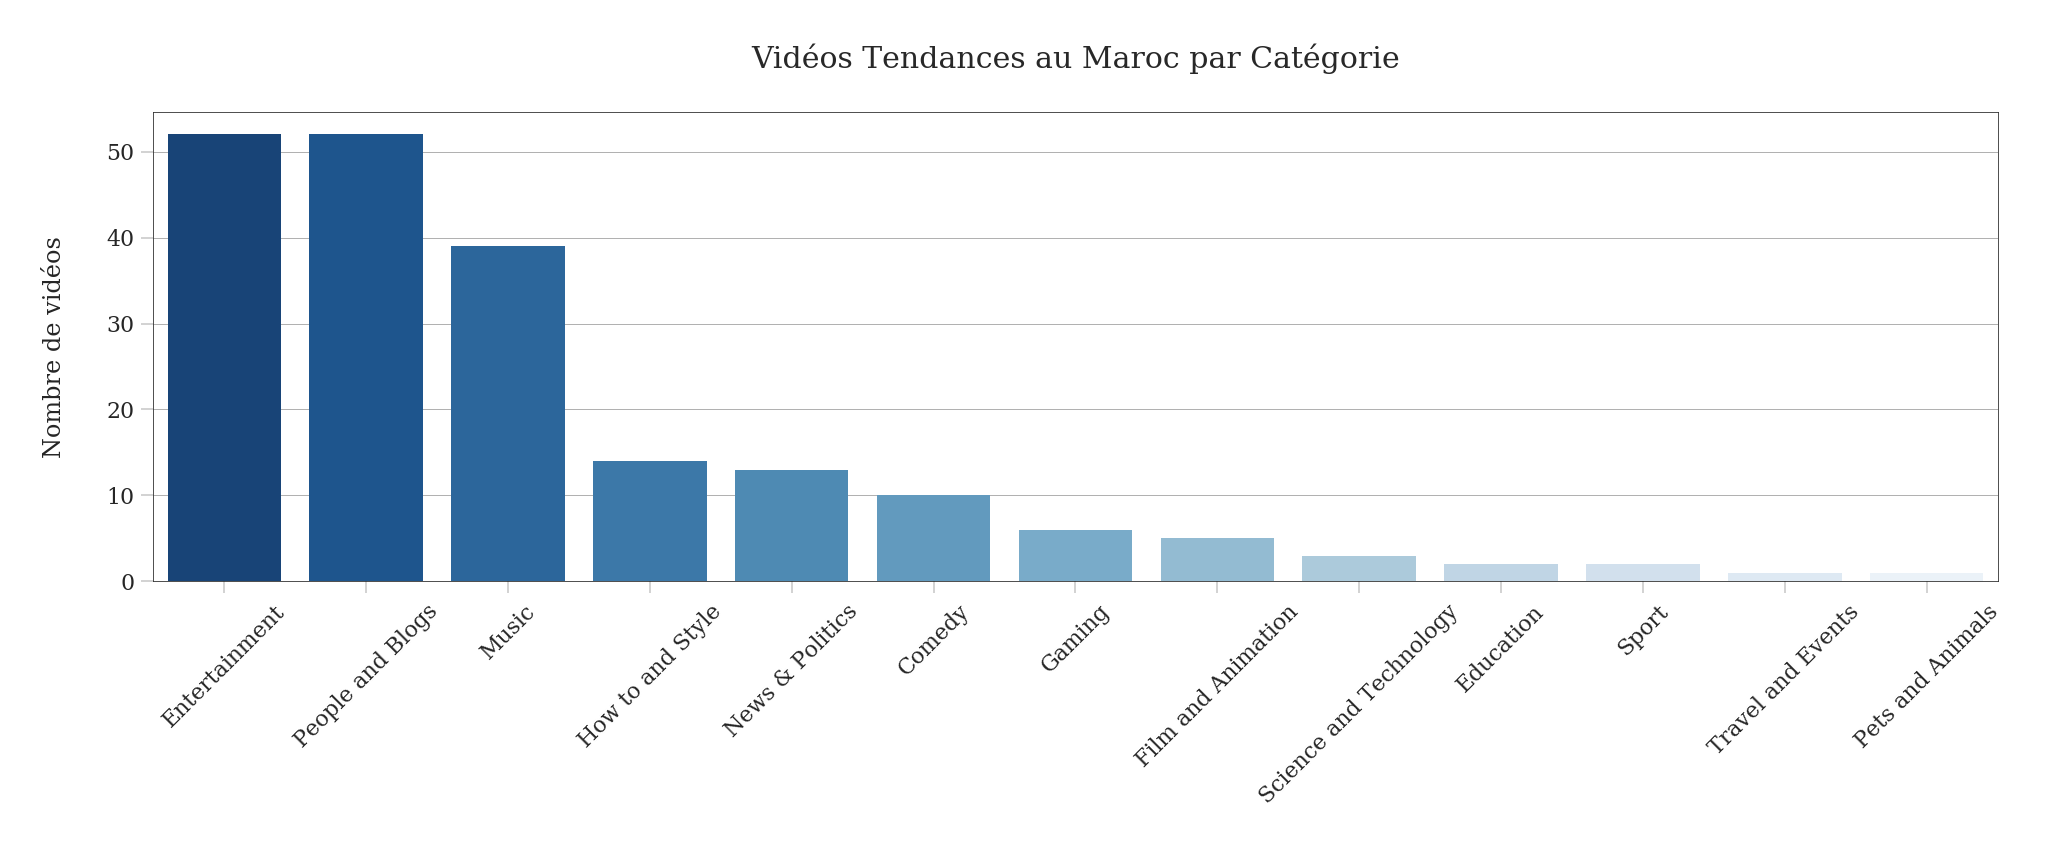

In [14]:
plt.figure(figsize = (14,9))

plt.subplot(211)
g = sns.countplot('Catégorie', data=Youtube[Youtube.Pays.eq('Morocco')], palette="Blues_r", 
                  order=Youtube[Youtube.Pays.eq('Morocco')]['Catégorie'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_title("Vidéos Tendances au Maroc par Catégorie\n", fontsize=15)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Nombre de vidéos", fontsize=12)

plt.tight_layout()
plt.show()

>#### Nous remarquons que les videos tendances au Maroc  sont en premier lieu des vidéos appartenant aux catégories :
    1️⃣Entertainment. 
    2️⃣People and Blogs. 
    3️⃣Music. 



> ### 🇲🇦 Le Nombre de Vues des Vidéos Tendances au Maroc par Catégorie.

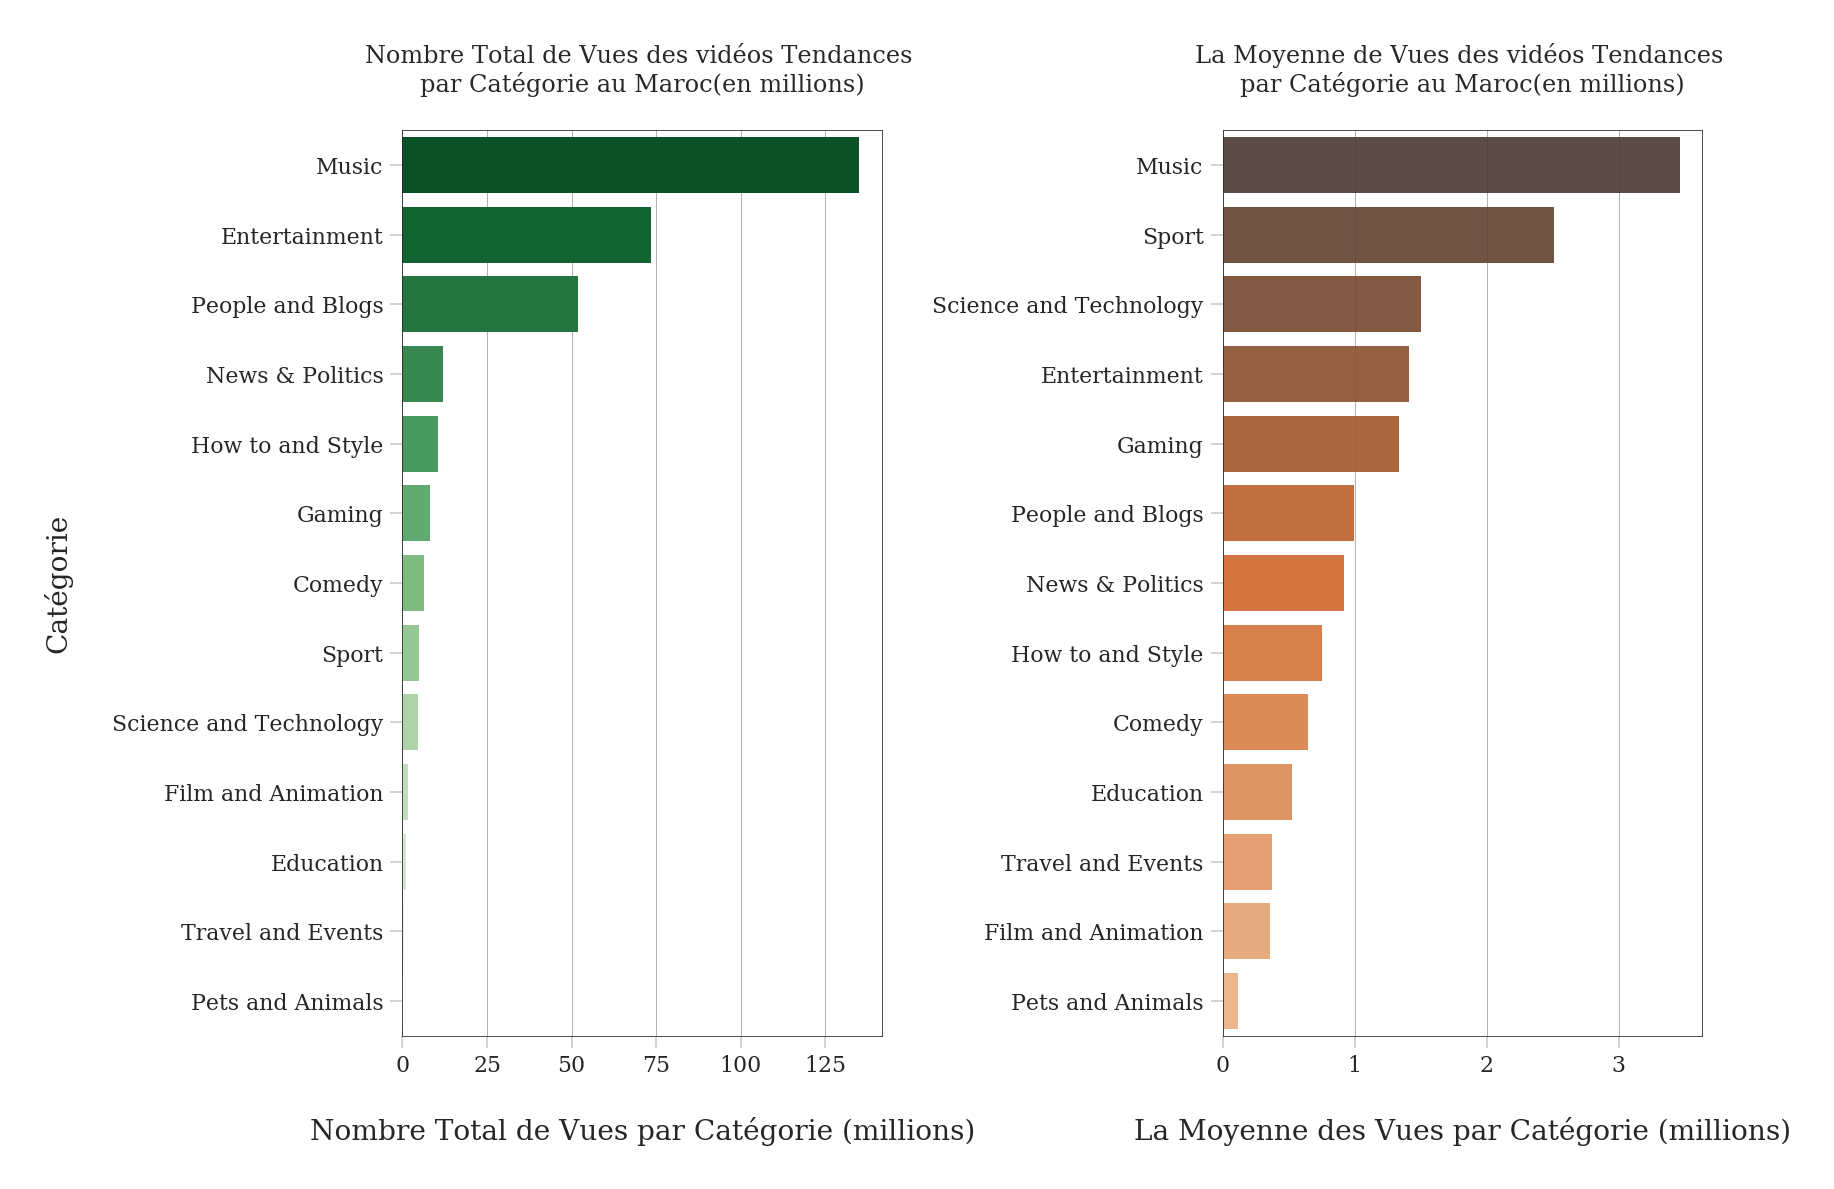

In [15]:
Total_Vues_Par_Catégorie = Youtube[Youtube.Pays.eq('Morocco')].groupby('Catégorie')['Nombre_Vues'].sum().sort_values(ascending=False)
Moyenne_Vues_Par_Catégorie = Youtube[Youtube.Pays.eq('Morocco')].groupby('Catégorie')['Nombre_Vues'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sns.barplot(y=Total_Vues_Par_Catégorie.index, x=(Total_Vues_Par_Catégorie/1000000), palette='Greens_r')
plt.xlabel('Nombre Total de Vues par Catégorie (millions)')
plt.ylabel('Catégorie')
plt.title('Nombre Total de Vues des vidéos Tendances \npar Catégorie au Maroc(en millions)\n')

plt.subplot(1,2,2)
sns.barplot(y=Moyenne_Vues_Par_Catégorie.index, x=(Moyenne_Vues_Par_Catégorie/1000000), palette='Oranges_d', alpha=0.9)
plt.xlabel('La Moyenne des Vues par Catégorie (millions)')
plt.ylabel('')
plt.title('La Moyenne de Vues des vidéos Tendances \npar Catégorie au Maroc(en millions)\n')

plt.tight_layout()
plt.show()

---
> #### Nous remarquons que les videos tendances au Maroc qui enregistrent le plus grand nombre de vues <br><br>sont ceux  appartenant aux catégories : 
    1️⃣ Music 🎶avec plus de 125 Millions 😲 de Vues.
    2️⃣ Entertainment avec plus de 70 Millions de Vues.
    3️⃣ People and Blogs avec plus de 50 Millions de Vues.
    

> ### 🇲🇦 La Distribution des Likes des Vidéos Tendances au Maroc par Catégorie.

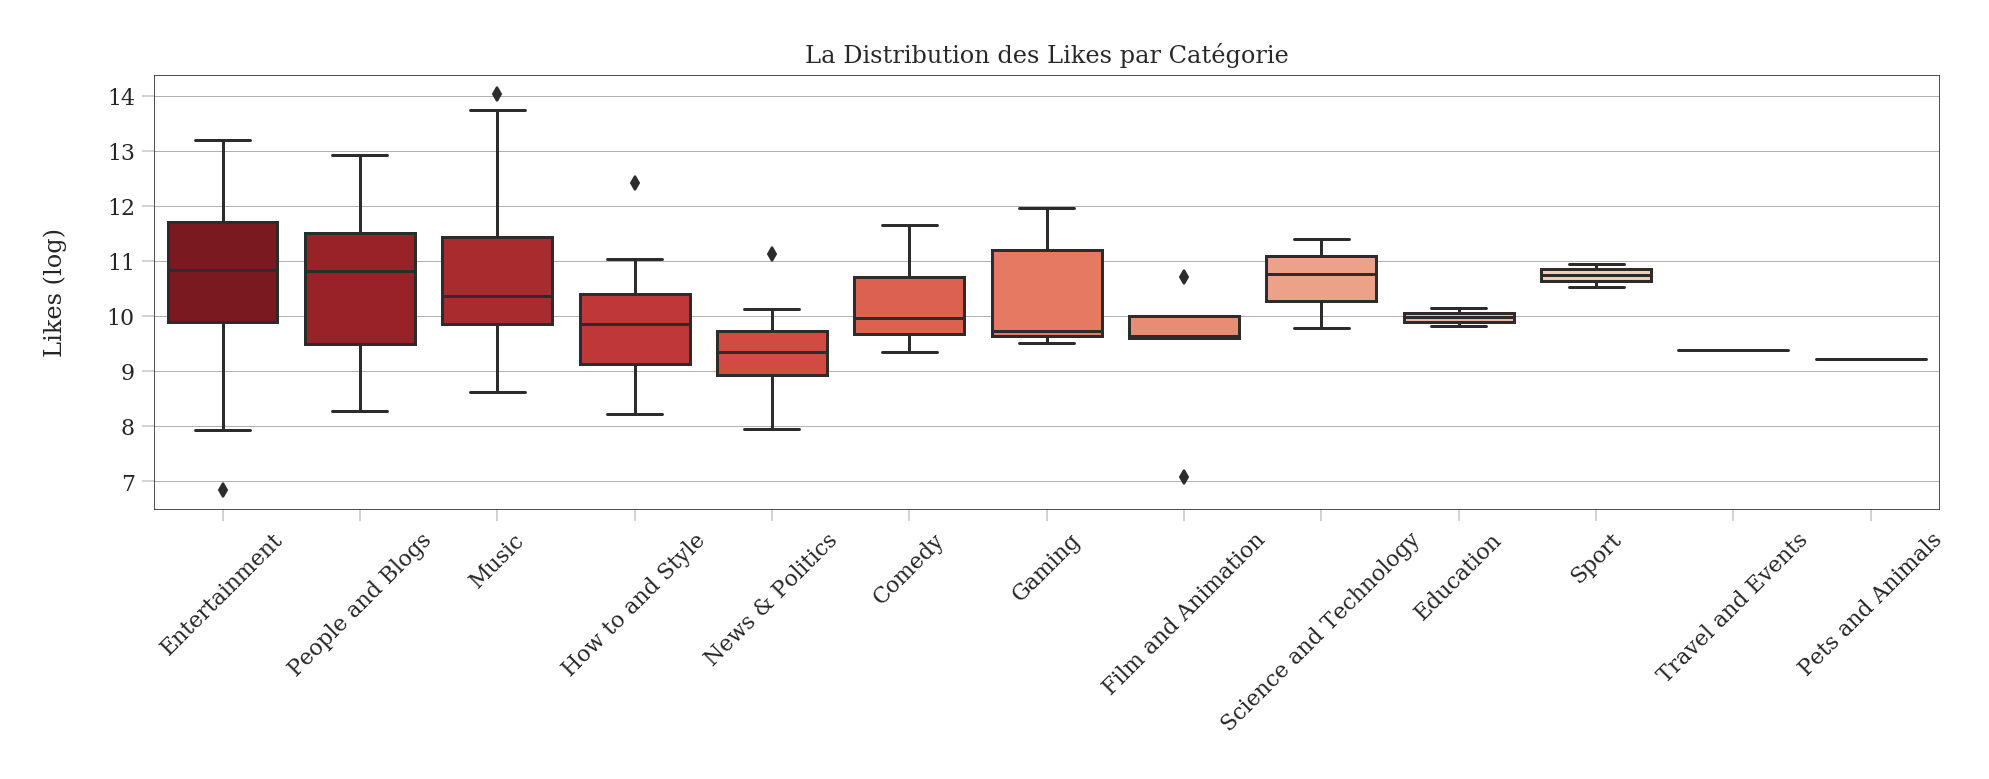

In [16]:
plt.figure(figsize = (16,4))

g2 = sns.boxplot(x='Catégorie', y=np.log(Youtube[Youtube.Pays.eq('Morocco')]['Likes'] + 1), 
                 data=Youtube[Youtube.Pays.eq('Morocco')], palette="Reds_r",
                order=Youtube[Youtube.Pays.eq('Morocco')]['Catégorie'].value_counts().index)
g2.set_xticklabels(g.get_xticklabels(),rotation=45)
g2.set_title("La Distribution des Likes par Catégorie", fontsize=12)
g2.set_xlabel("", fontsize=12)
g2.set_ylabel("Likes (log)", fontsize=12)
plt.show()

---
> #### Nous remarquons que les videos tendances au Maroc qui enregistrent le plus grand nombre de Likes <br><br>sont celles appartenant aux catégories : 
    1️⃣ Entertainment.
    2️⃣ People and Blogs. 
    3️⃣ Music.

> ### ✅ La Distribution Normale des caractéristiques d'une vidéo.

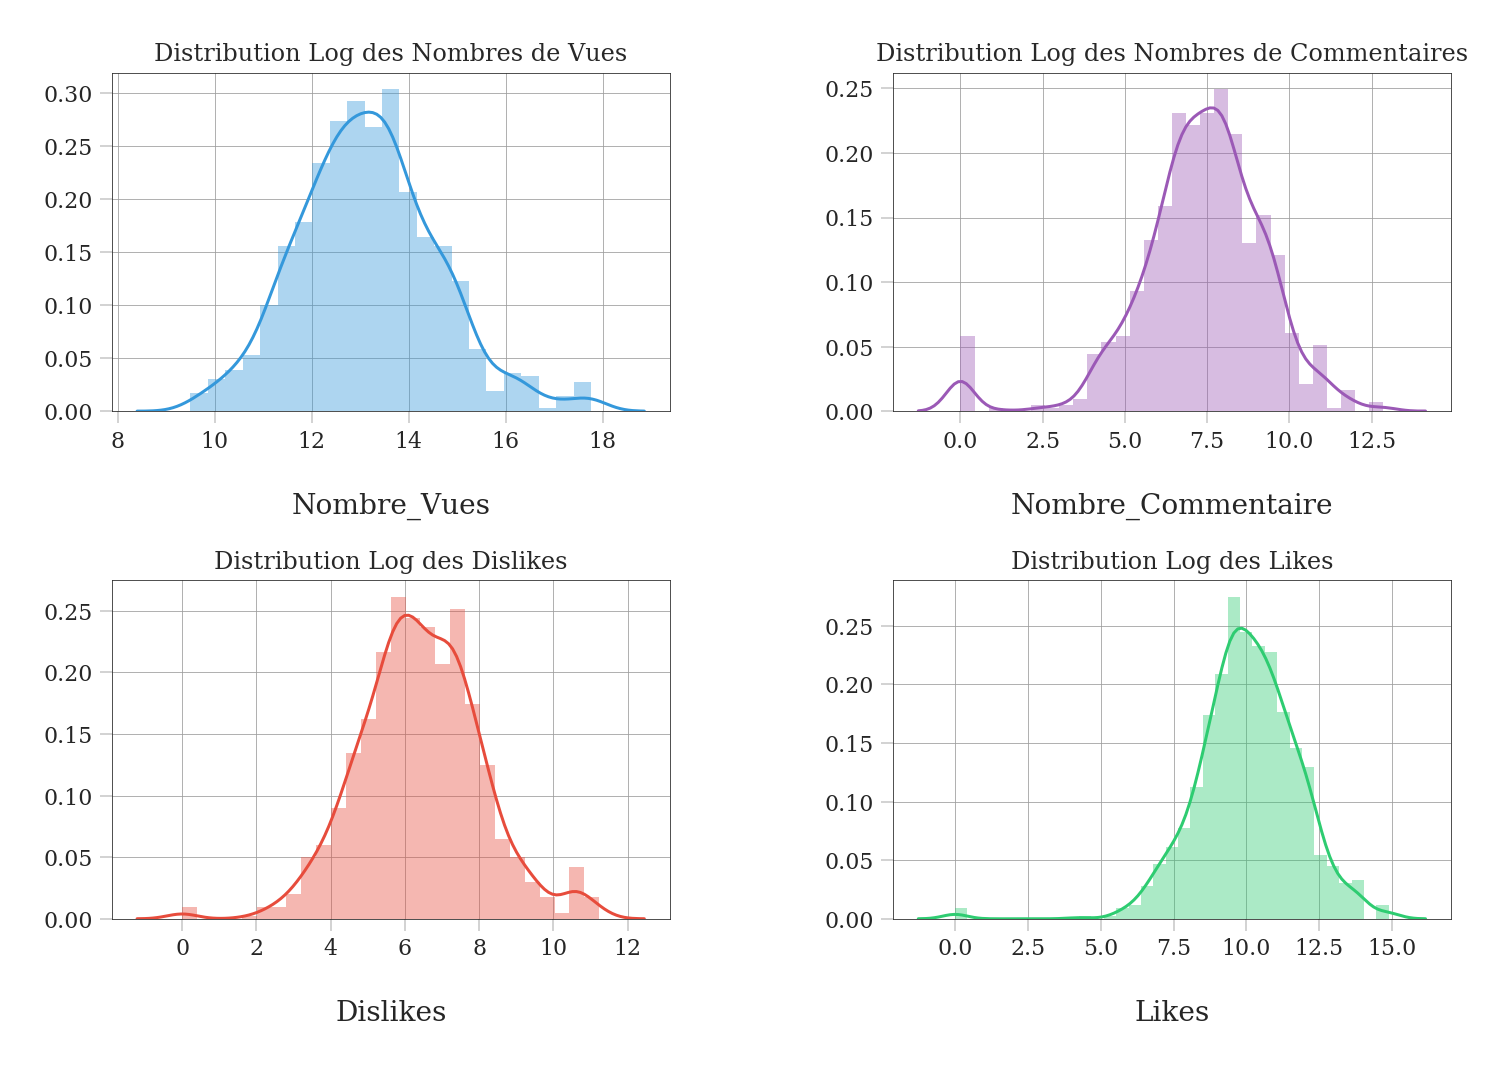

In [28]:
plt.figure(figsize = (12,5))

plt.subplot(221)
g1 = sns.distplot(np.log(Youtube['Nombre_Vues'] + 1), color='#3498db')
g1.set_title("Distribution Log des Nombres de Vues", fontsize=12)

plt.subplot(224)
g2 = sns.distplot(np.log(Youtube['Likes'] + 1),color='#2ecc71')
g2.set_title('Distribution Log des Likes', fontsize=12)

plt.subplot(223)
g3 = sns.distplot(np.log(Youtube['Dislikes'] + 1), color='#e74c3c')
g3.set_title("Distribution Log des Dislikes", fontsize=12)

plt.subplot(222)
g4 = sns.distplot(np.log(Youtube['Nombre_Commentaire'] + 1), color='#9b59b6')
g4.set_title("Distribution Log des Nombres de Commentaires", fontsize=12)

plt.subplots_adjust(wspace = 0.4, hspace = 0.5,top = 1.3)

plt.show()

> ### 🇲🇦 La corrélation entre les différentes caractéristiques des Vidéos Tendances au Maroc.

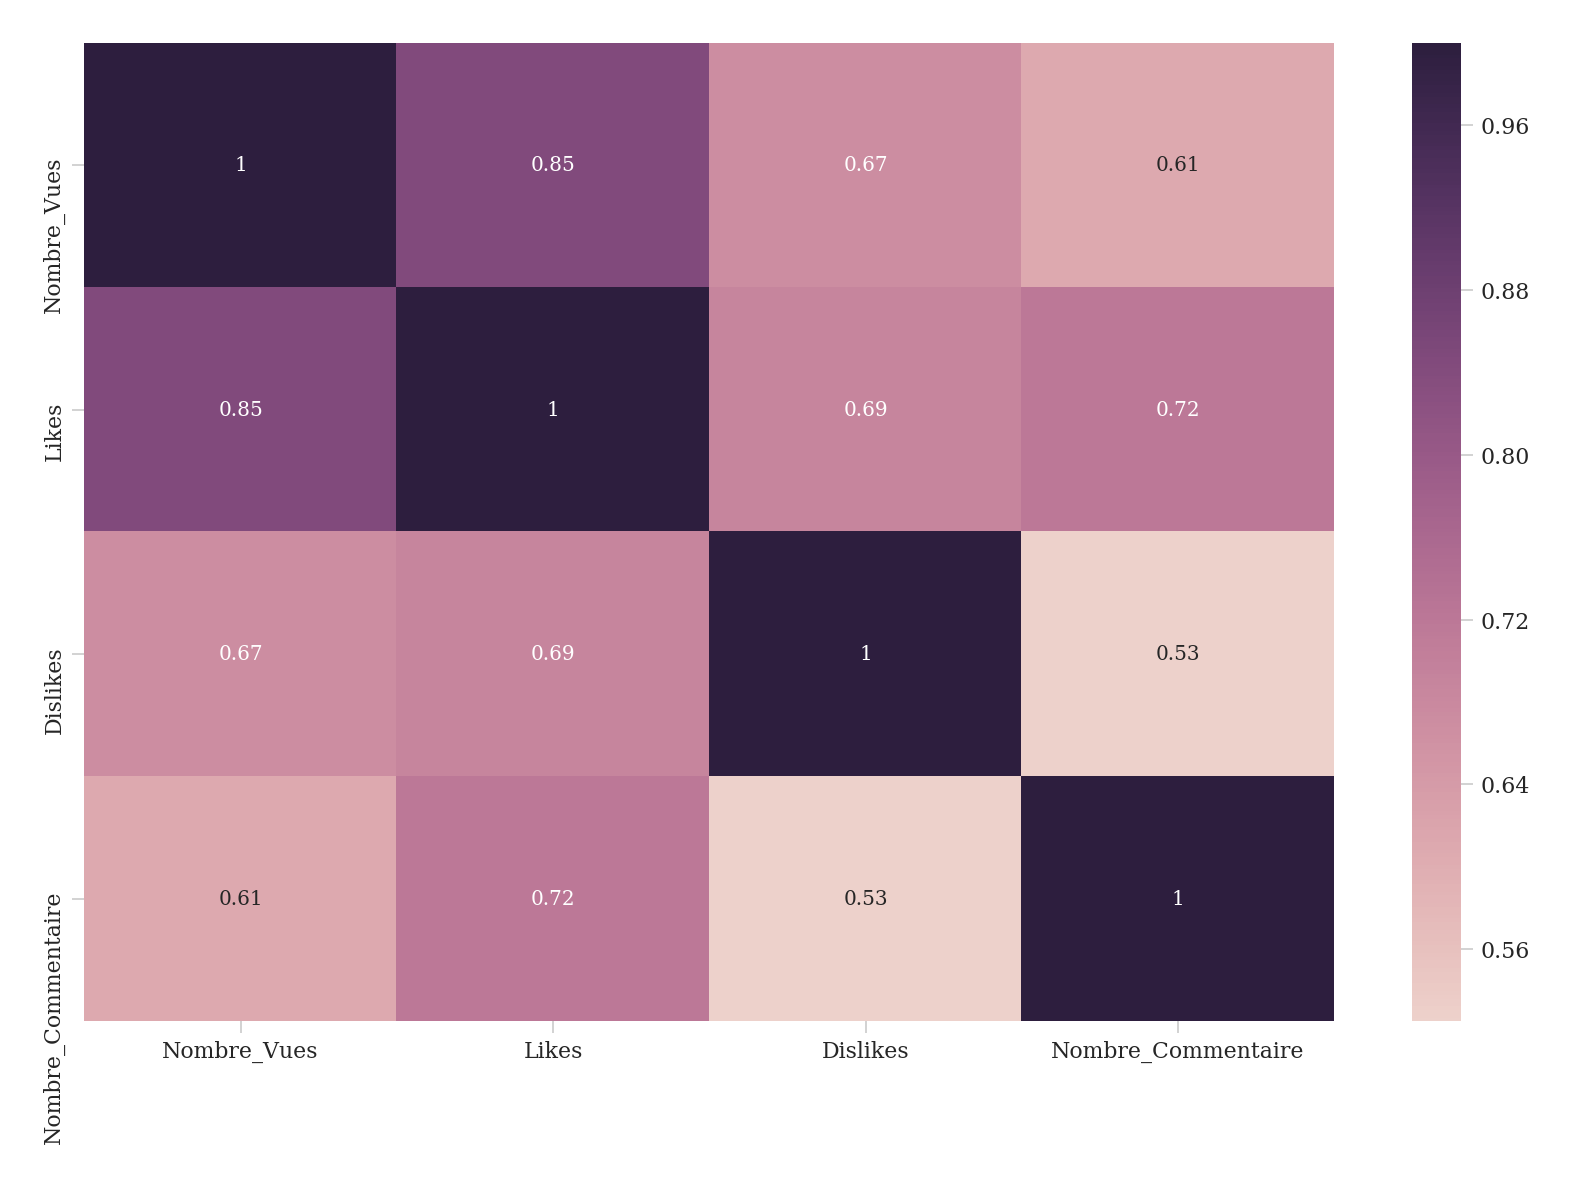

In [17]:
fig, ax = plt.subplots(figsize=(14,9))
_ = sns.heatmap(Youtube[Youtube.Pays.eq('Morocco')][['Nombre_Vues', 'Likes', 'Dislikes', 'Nombre_Commentaire']].corr(), annot=True,
                cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.show()

> #### Nous remarquons : 
>> - Une forte corrélation entre le Nombre de Vues et les Likes.
>> - Une forte corrélation entre le Nombre de commentaires et les Likes. 

> #### Comme la carte de corrélation ci-dessus indique que les Vues et les Likes sont fortement corrélés positivement. <br><br>  Vérifions ça en traçant le nuage de points pour visualiser la relation entre entre les deux variables.

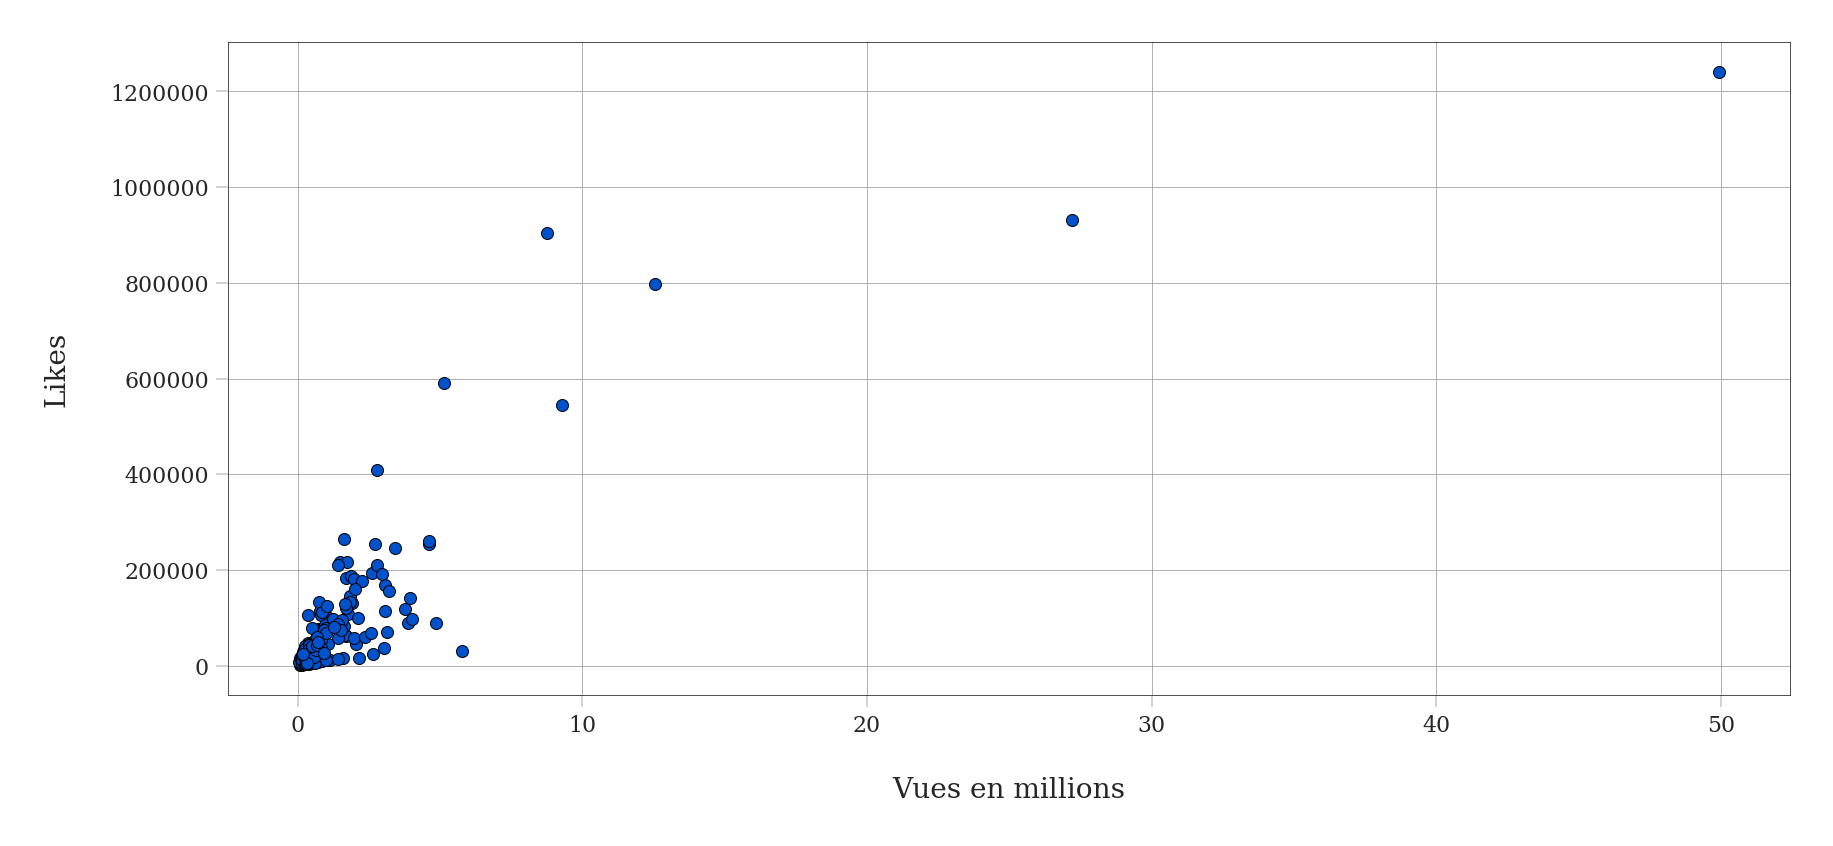

In [18]:
fig, ax = plt.subplots(figsize=(14,6))
_ = plt.scatter(x=Youtube[Youtube.Pays.eq('Morocco')]['Nombre_Vues']/1000000, 
                y=Youtube[Youtube.Pays.eq('Morocco')]['Likes'], 
                color=PLOT_COLORS[1], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Vues en millions", ylabel="Likes")

> ### Vérifions le cas des Autres Pays : 🇮🇹🇫🇷🇺🇸🇪🇸

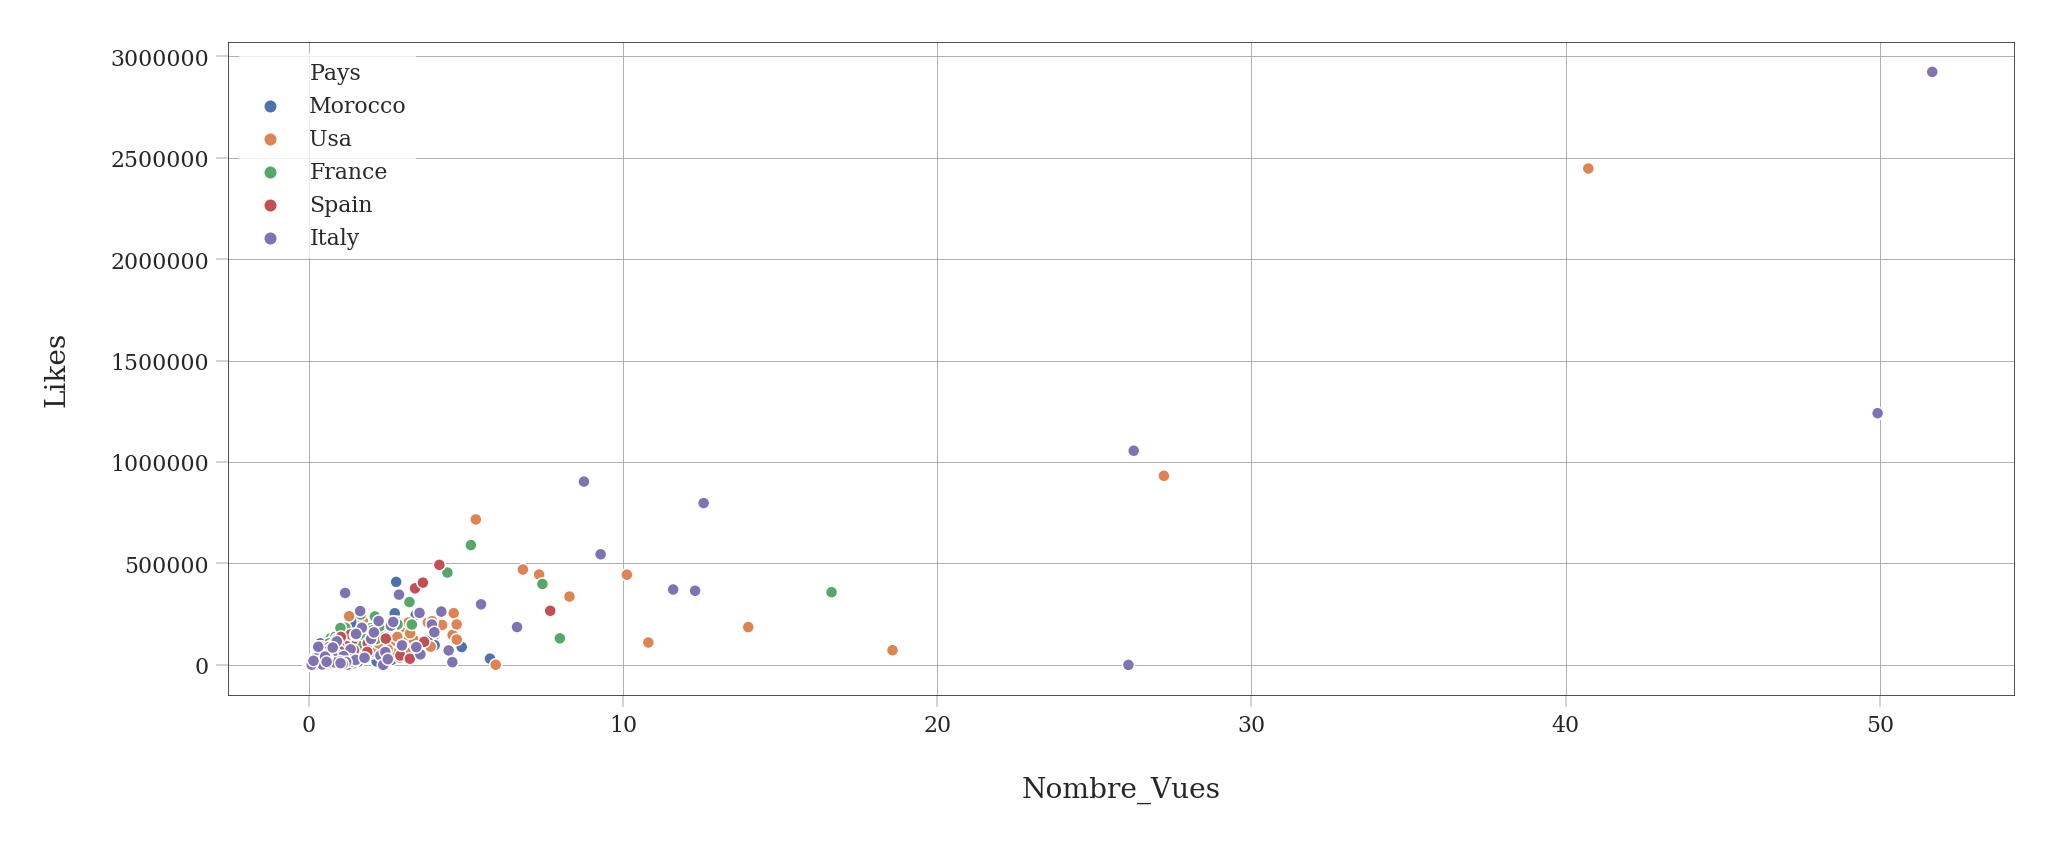

In [38]:
fig = plt.subplots(figsize=(16,6))
sns.scatterplot(x=Youtube["Nombre_Vues"]/1000000, y=Youtube["Likes"], 
                hue=Youtube["Pays"], edgecolors="#000000", linewidths=2)

 > ## ✔️ Régression Linéaire 📉

> ### Sélection des Variables

In [147]:
X = Youtube[Youtube.Pays.eq('Morocco')]['Nombre_Vues'].values.reshape(-1,1)
y = Youtube[Youtube.Pays.eq('Morocco')]['Likes'].values.reshape(-1,1)

> ### Visualisation 

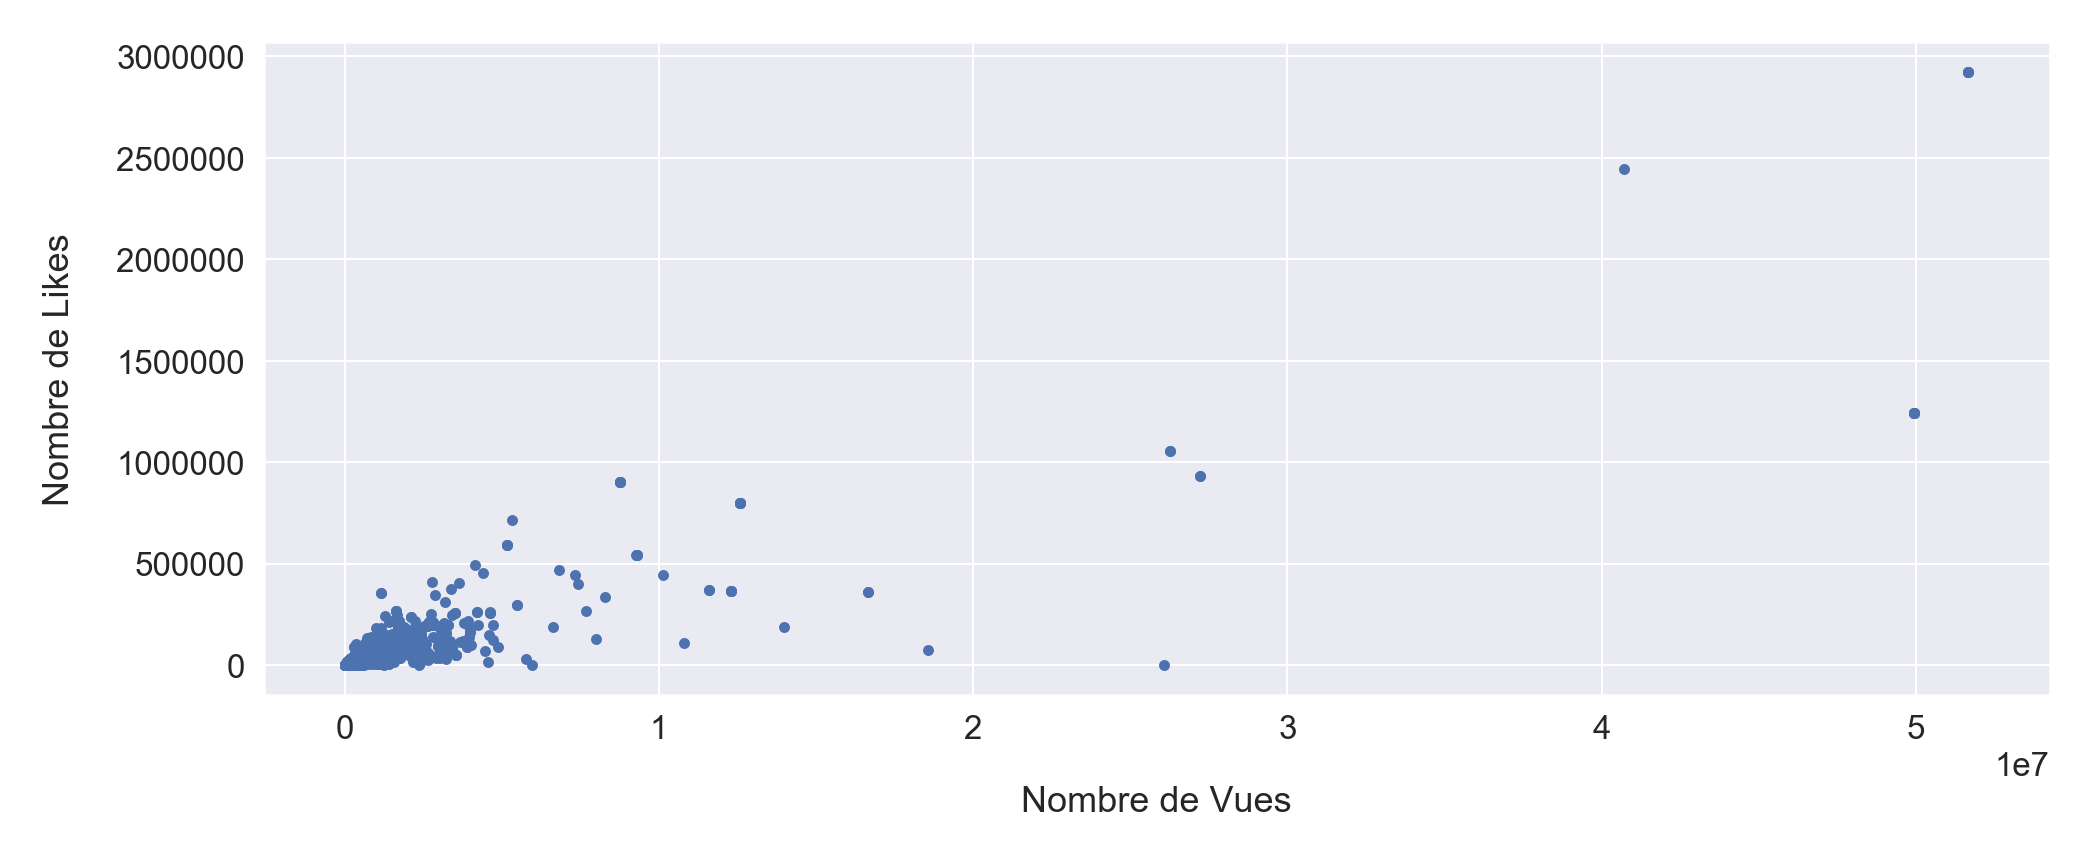

In [148]:
matplotlib_axes_logger.setLevel('ERROR')
Youtube.plot(kind='scatter', x="Nombre_Vues", y='Likes', figsize=(16,6))
plt.ylabel("Nombre de Likes")
plt.xlabel("Nombre de Vues")

plt.show()

> ### Training

In [149]:
import sklearn
from sklearn.linear_model import LinearRegression

lrModel = sklearn.linear_model.LinearRegression()

# Train the model
lrModel.fit(X, y)

#model parameters
theta0, theta1 = lrModel.intercept_[0], lrModel.coef_[0][0]

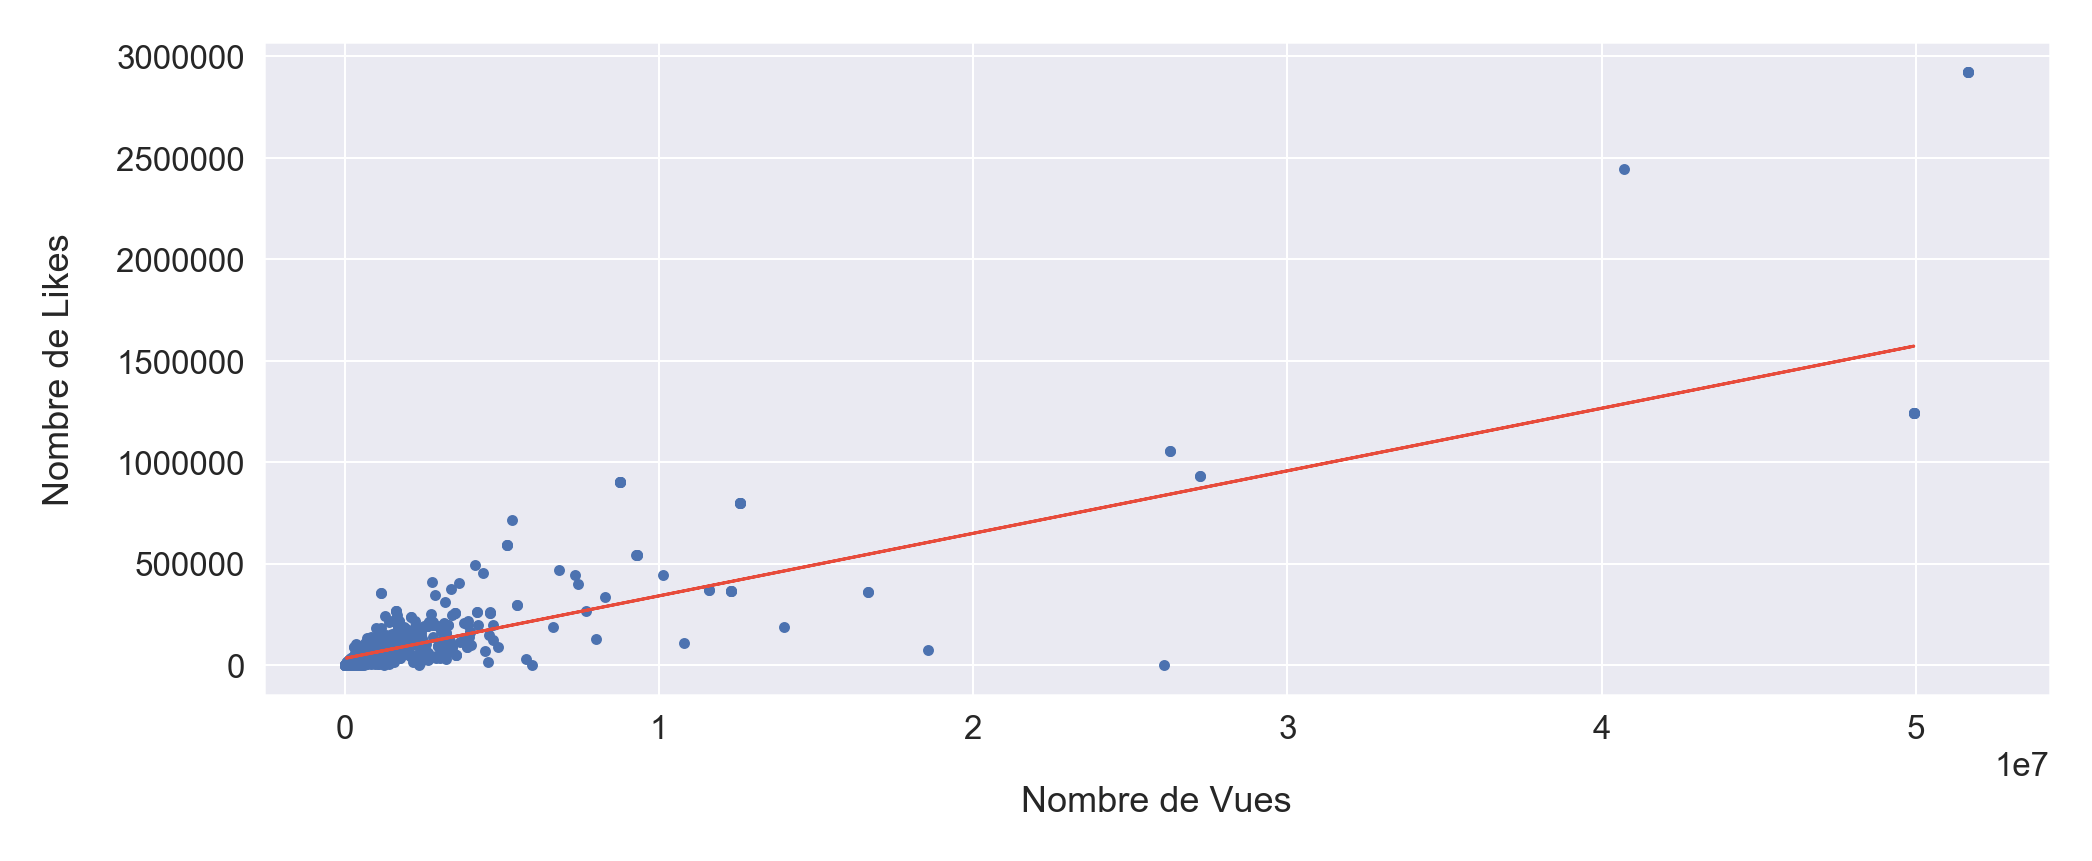

In [150]:
matplotlib_axes_logger.setLevel('ERROR')
#plot
Youtube.plot(kind='scatter', x="Nombre_Vues", y='Likes', figsize=(16,6))
plt.ylabel("Nombre de Likes")
plt.xlabel("Nombre de Vues")

plt.plot(X, theta0 + theta1*X, 'b',color="#e74c3c")
#save_fig('best_fit_model_plot')
plt.show()

> ### Accuracy du Modèle

In [151]:
print('Accuracy : Linear regression score :{} %'.format(lrModel.score(X, y)*100))

Accuracy : Linear regression score :71.60078282261608 %


> ### Prediction

    Prediction pour une vidéo Tendance au Maroc avec 1M de Vues

In [152]:
# Prediction pour une vidéo Tendance au Maroc avec 1M vues
X_new = [[1000000]]  # vidéo Tendance au Maroc avec 1M vues
print('Elle va probablement avoir :{} Likes'.format(lrModel.predict(X_new))) 

Elle va probablement avoir :[[64107.4027675]] Likes


---
> ## ✔️ Machine Learning : Une Plus Grande Base de Données : 
- **Les vidéos YouTube à tendance quotidienne dans USA 🇺🇸durant plusieurs mois**

        ⚠️ Nous travaillons cette fois sur une Base Compléte

> ### ✅ Data-PreProcess

In [128]:
USA = pd.read_csv('ML_Project/DataBase/USvideos.csv')

In [129]:
USA.shape

(23362, 16)

In [135]:
USA.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,2017-11-14,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,2017-11-14,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [130]:
USA['trending_date'] = pd.to_datetime(USA['trending_date'], format='%y.%d.%m')
USA['publish_time'] = pd.to_datetime(USA['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
USA['publish_time'] = USA['publish_time'].dt.date

#Drop Column no useful
USA = USA.drop(['video_id', 
              'channel_title',
              'category_id',
              'tags',
              'thumbnail_link',
              'comments_disabled',
              'ratings_disabled',
              'description',
            'video_error_or_removed'], axis=1)

#Drop des NAs
USA = USA.dropna(how='any',axis=0)

#Renommage
USA.columns = ['Tendance_Date',
                   'Titre',
                   'Date_Publication',
                   'Nombre_Vues',
                   'Likes',
                   'Dislikes',
                   'Nombre_Commentaire'] 

> ### ✅ Importation des Librarys Necéssaires

In [174]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

> ### ✅ Arbres de Décisions : DecisionTreeRegressor
---

    ▶︎ Prédiction des Nombres de Vues des videos Tendances ◀︎

In [179]:
# Create target object and call it y
y = USA.Nombre_Vues
# Create X
features = ['Likes', 'Dislikes', 'Nombre_Commentaire']
X = USA[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Specify Model
iowa_model = DecisionTreeRegressor(random_state=1)

# Fit Model
iowa_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = iowa_model.predict(val_X)

val_mae = mean_absolute_error(val_predictions, val_y)

print("Validation MAE: {:,.0f}".format(val_mae))

print('Accuracy : DecisionTree score :{} %'.format(iowa_model.score(X, y)*100))

print("\n")

d1 = {'Valeurs réelles': val_y, 'Valeurs Prédites': val_predictions}
SK1 = pd.DataFrame(data = d1)
print(SK1)

Validation MAE: 509,766
Accuracy : DecisionTree score :91.40245181626852 %


       Valeurs réelles  Valeurs Prédites
4166              1315           1375.00
21720          1583596        1761701.00
16767           435619         320792.00
17685           323571         327421.00
16561           752354        1194195.00
...                ...               ...
12912           341197         187679.00
10282             7251          52038.00
3922             64044          51934.00
16482          2683691        2822899.00
3500             82526          77201.00

[5841 rows x 2 columns]


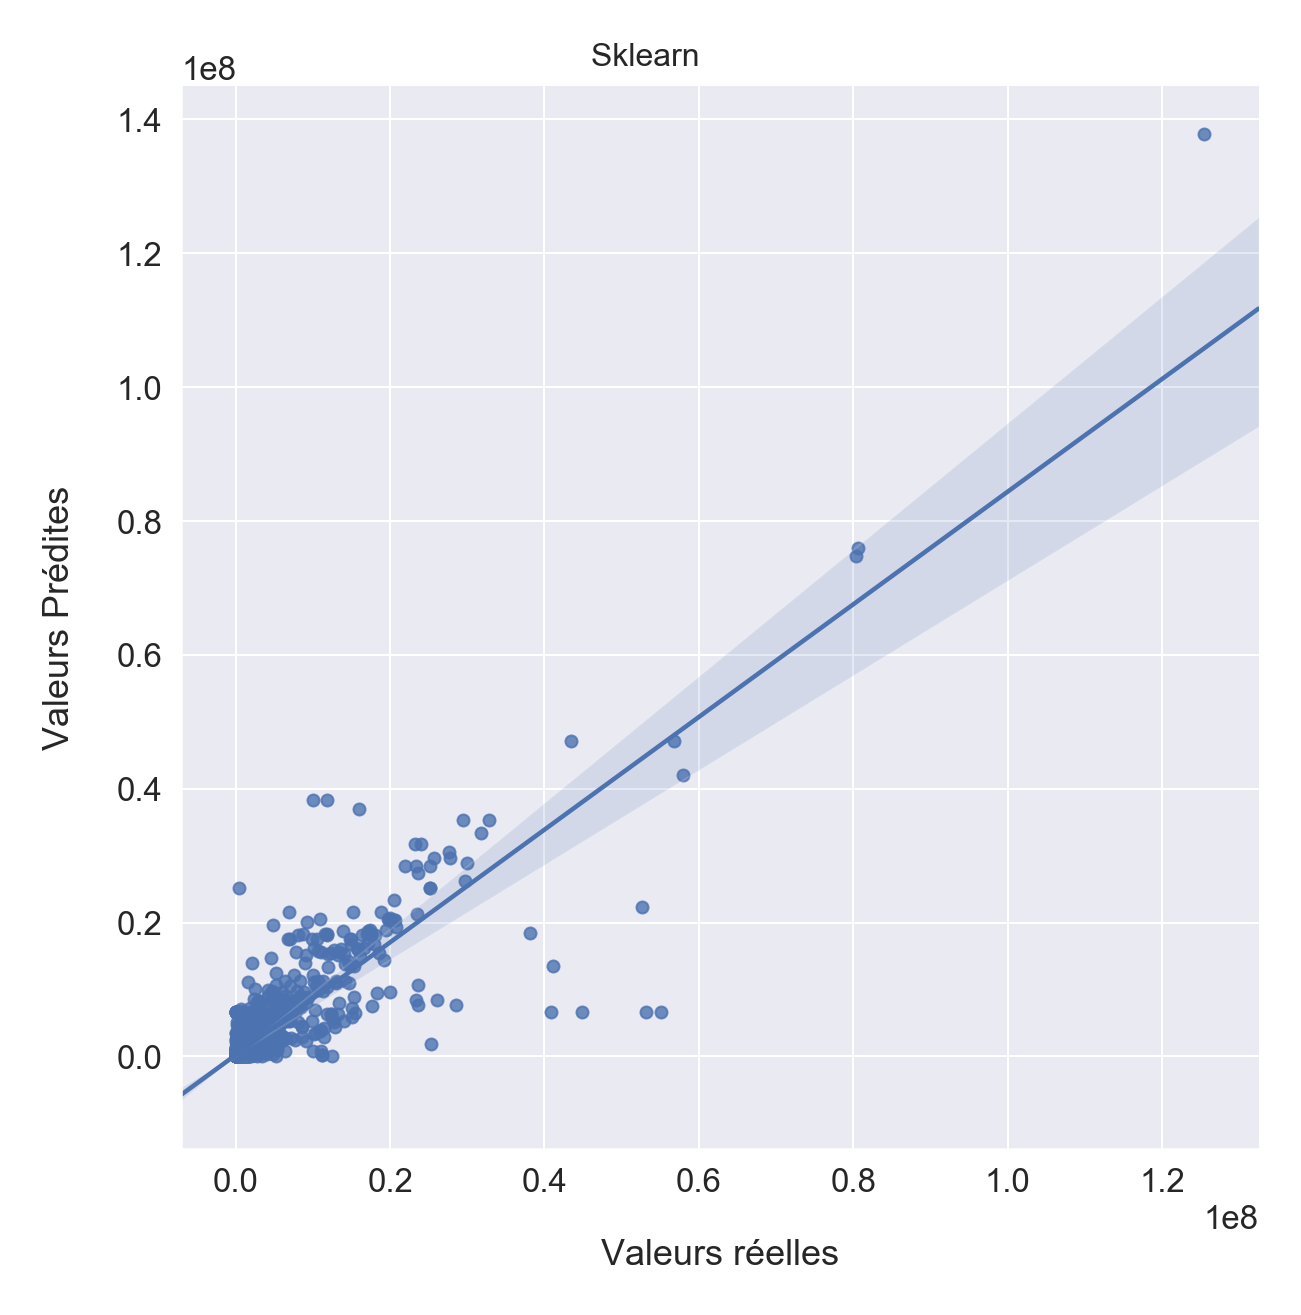

In [169]:
lm1 = sns.lmplot(x="Valeurs réelles", y="Valeurs Prédites", data = SK1, height = 9)
fig1 = lm1.fig 
fig1.suptitle("Sklearn ", fontsize=16)
sns.set(font_scale = 1.5)

> ### ✅ Forêts Aléatoires : RandomForest

In [171]:
# Define the model. Set random_state to 1
rf_model = RandomForestRegressor(random_state=1)

# fit your model
rf_model.fit(train_X,train_y)
val_predictions1 = rf_model.predict(val_X)

# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(val_predictions1, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))
print('Accuracy : Random Forest score :{} %'.format(rf_model.score(X, y)*100))
print('\n')

d2 = {'Valeurs réelles': val_y, 'Valeurs Prédites': val_predictions1}
SK2 = pd.DataFrame(data = d2)
print(SK2)

/Users/manouzioutmanimouad/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Validation MAE for Random Forest Model: 463,689
Accuracy : Random Forest score :90.99532856187942 %


       Valeurs réelles  Valeurs Prédites
4166              1315           1345.70
21720          1583596        1381781.00
16767           435619         575093.80
17685           323571         284373.20
16561           752354        1437819.00
...                ...               ...
12912           341197        1168879.00
10282             7251          36128.30
3922             64044          63409.60
16482          2683691        2435700.40
3500             82526         112583.10

[5841 rows x 2 columns]


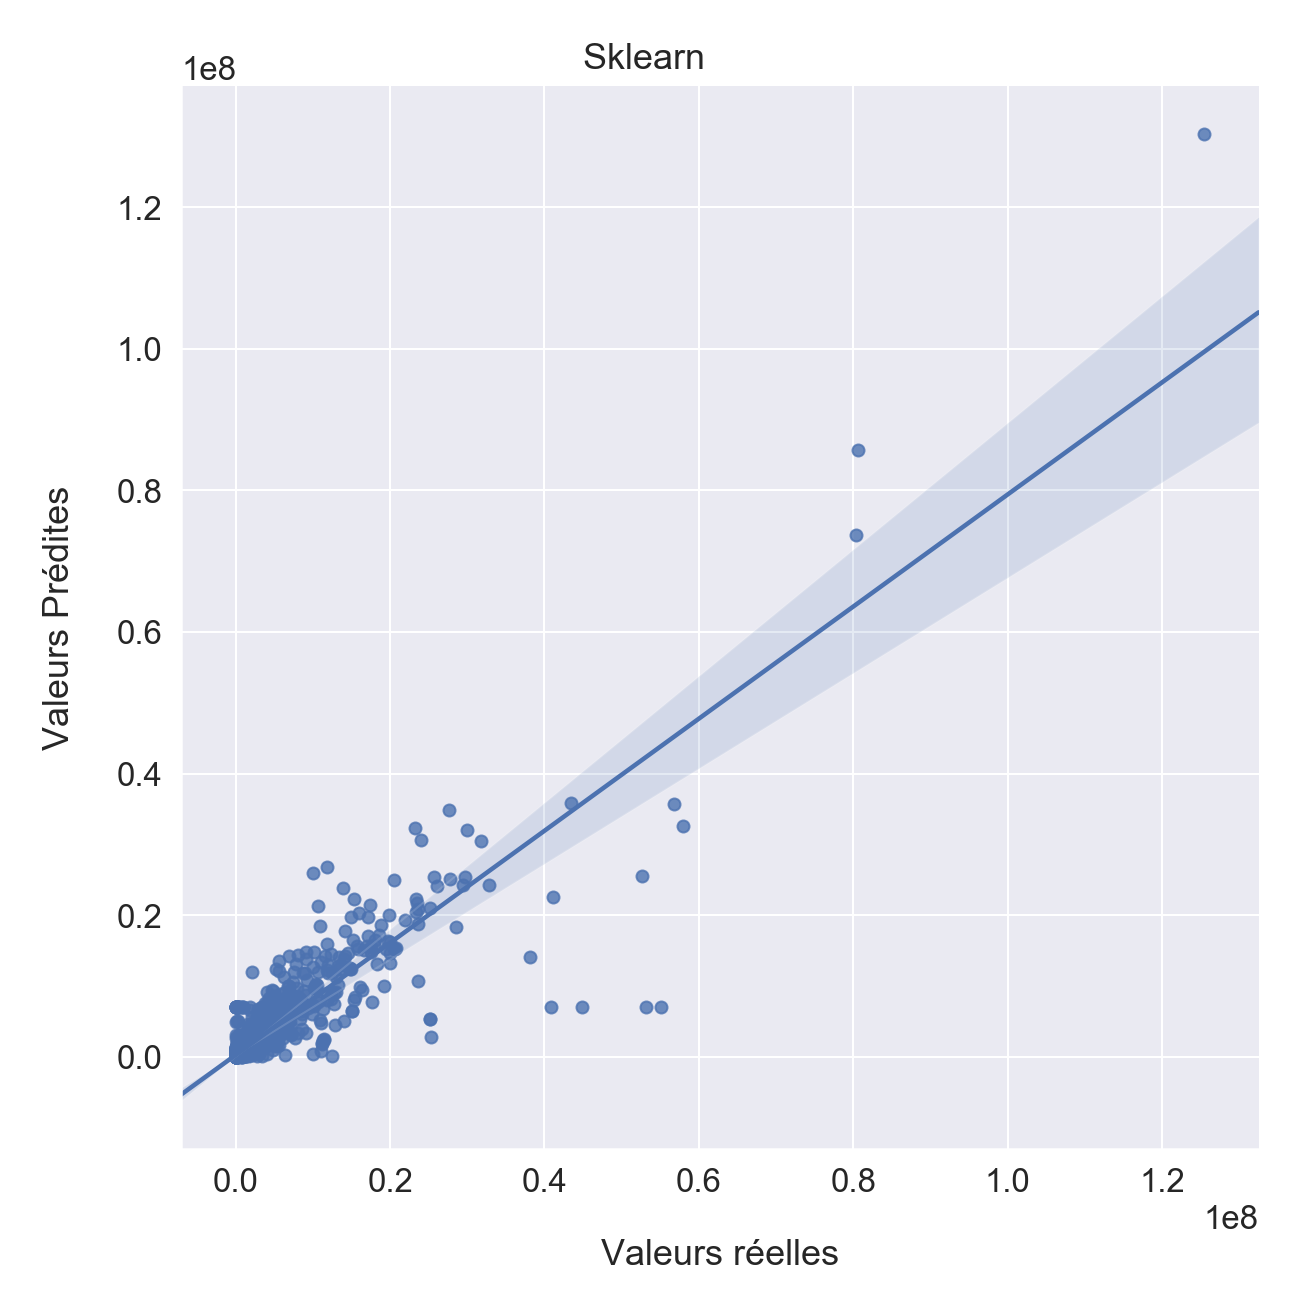

In [172]:
lm1 = sns.lmplot(x="Valeurs réelles", y="Valeurs Prédites", data = SK2, height = 9)
fig1 = lm1.fig 
fig1.suptitle("Sklearn ", fontsize=18)
sns.set(font_scale = 1.5)

>> **Hyper-Parameter Turning**

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  7.6min finished


Best HyperParameter:  {'max_depth': 25, 'n_estimators': 160}
0.8657113735826901


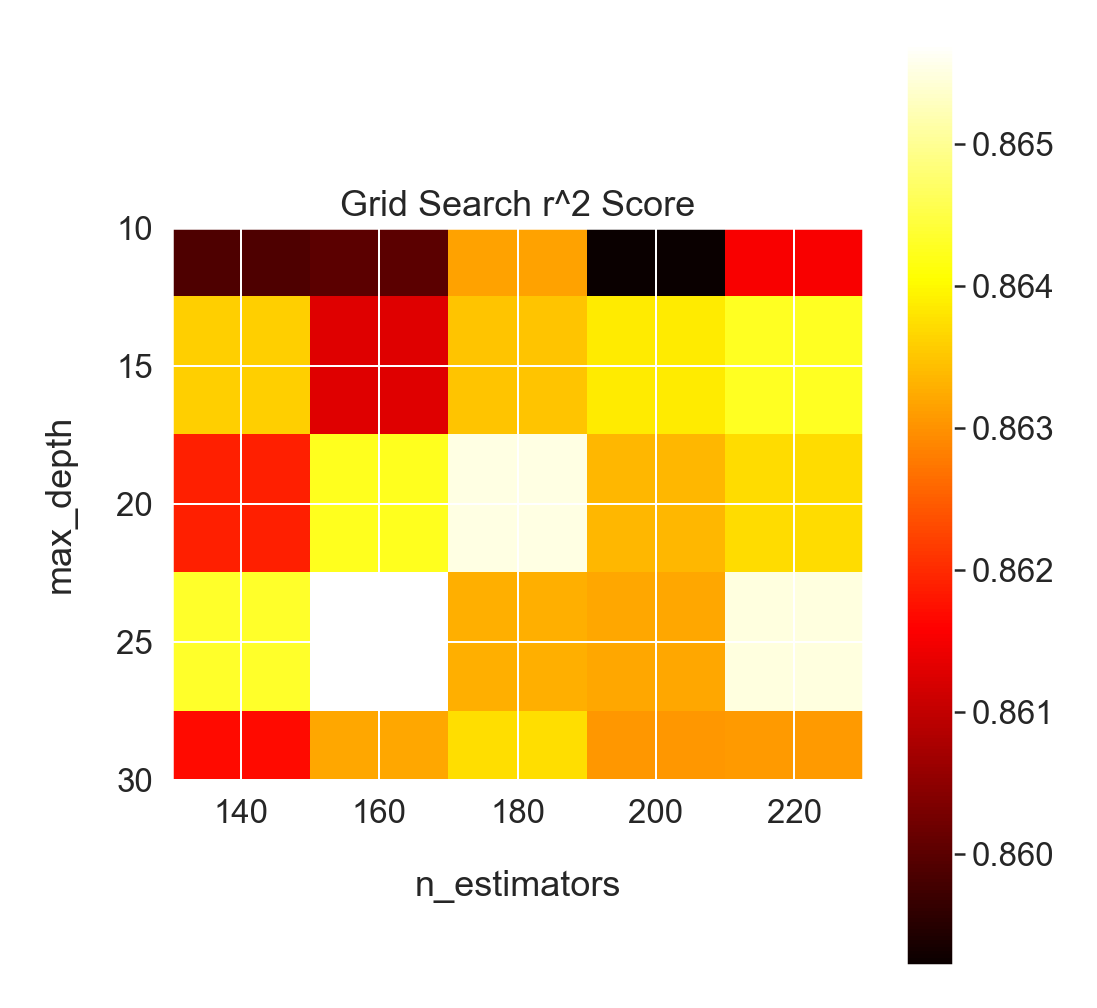

In [146]:
nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()

hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(train_X,train_y)

print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

> ### Random Forest using Optimal Hyperparameter : 
    160 Estimateurs et 25 en Profondeur maximale.

In [175]:
model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(train_X,train_y)

# predicting the  test set results
y_pred = model.predict(val_X)
rf_val_mae = mean_absolute_error(y_pred, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))
print('Root means score', np.sqrt(mean_squared_error(y_pred, val_y)))
print("Accuracy : RandomForest score :{} % :",model.score(X, y)*100)
print("\n")

d3 = {'Valeurs réelles': val_y, 'Valeurs Prédites': y_pred}
SK3 = pd.DataFrame(data = d3)
print(SK3)

Validation MAE for Random Forest Model: 443,507
Root means score 1712153.5631483581
Accuracy : RandomForest score :{} % : 91.85131726748482


       Valeurs réelles  Valeurs Prédites
4166              1315           1531.03
21720          1583596        1463069.94
16767           435619         468170.13
17685           323571         402658.96
16561           752354        1373703.22
...                ...               ...
12912           341197         734284.67
10282             7251          32382.04
3922             64044          83584.62
16482          2683691        2500187.46
3500             82526          90885.85

[5841 rows x 2 columns]


> ## ✅ Conclusion : BenchMarking
    Views Predicition
| Model                                         |    Score                   | Erreur Moyenne Absolue |
|---------------                                | ---------------------------| ---------------------- |
|   DecisionTree                                | 91.40%                     |       509,766          |
|   RandomForest                                | 91.00%                     |       463,689          |
|   RandomForest using Optimal Hyperparameter   | 91.85%                     |       443,507          |